In [269]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torcheval.metrics import R2Score
import sympy as sp
import torch_optimizer
import scipy
from torch.nn.utils import parameters_to_vector as Params2Vec, vector_to_parameters as Vec2Params

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [75]:
num_samples = 1000

In [283]:
class Net_general(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, activation_function = torch.relu):
        super(Net_general, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, 1))
        self.activation_function = activation_function

    def forward(self, x, activations=False):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
        if activations:
            return x
        x = self.layers[-1](x)
        return x

In [291]:
def create_dataset(x, f, test_size=0.2):
    '''Create a dataset from a function f and input x. The function returns a tuple of train and test datasets.'''
    y = f(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)

    x_train, y_train, x_test, y_test = map(torch.tensor, (x_train, y_train, x_test, y_test))
    train_dataset = TensorDataset(x_train.float(), y_train.float())
    test_dataset = TensorDataset(x_test.float(), y_test.float())

    return train_dataset, test_dataset

In [192]:
def train_and_evaluate(net, criterion, optimizer, train_loader, test_loader, num_epochs=1000, activations=False):
    '''Train and evaluate a network. Returns the outputs of the network and the train losses.'''
    train_losses = []
    net.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward(create_graph=True)
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))

    net.eval()
    test_loss = 0
    all_outputs = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = net(inputs, activations=activations)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            all_outputs.append(outputs)
            all_targets.append(targets)
            

    test_loss /= len(test_loader)
    print('Test Loss: %.6f' % test_loss)

    score = R2Score()
    score.update(torch.cat(all_targets).view(torch.cat(all_targets).shape[0], 1), torch.cat(all_outputs))
    r2score = score.compute()
    print('R2 Score: %.6f' % r2score)
    
    return torch.cat(all_outputs), train_losses, test_loss

In [59]:
def plot_losses_and_predictions(test_dataset, train_losses, outputs):
    '''Plot the losses and predictions of a network.'''
    plt.plot(test_dataset.tensors[0].numpy(), test_dataset.tensors[1].numpy(), 'o' ,label='True values')
    plt.plot(test_dataset.tensors[0].numpy(), outputs.numpy(), 'o' ,label='Predictions')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.show()

# Q1 (equidistant sampling)

In [51]:
def f_q1(x):
    '''The function for question 1.'''
    return 1 / (1 + 25 * x**2)

Test Loss: 0.000010
R2 Score: 0.999859
Test loss: 0.000010


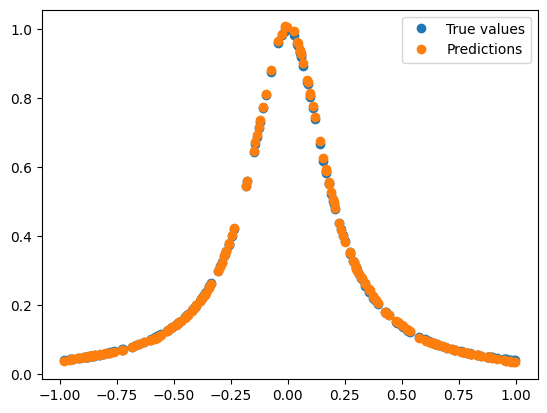

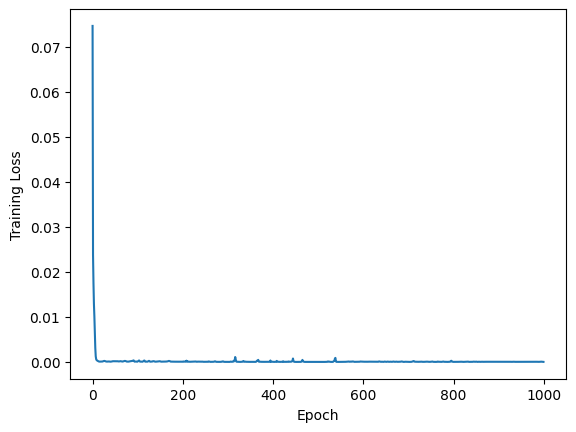

In [194]:
train_dataset_q1_eq, test_dataset_q1_eq = create_dataset( np.linspace(-1, 1, num_samples).reshape(-1, 1) ,f_q1)

train_loader_q1_eq = DataLoader(train_dataset_q1_eq, batch_size=32)
test_loader_q1_eq = DataLoader(test_dataset_q1_eq, batch_size=32)

net_q1_eq = Net_general(1,50,2)
criterion_q1_eq = nn.MSELoss()
optimizer_q1_eq = optim.Adam(net_q1_eq.parameters(), lr=0.01)

outputs_q1_eq, train_losses_q1_eq, test_loss_q1_eq = train_and_evaluate(net_q1_eq, criterion_q1_eq, optimizer_q1_eq, train_loader_q1_eq, test_loader_q1_eq)
print('Test loss: %.6f' % test_loss_q1_eq)
plot_losses_and_predictions(test_dataset_q1_eq, train_losses_q1_eq, outputs_q1_eq)

# Q2 random sampling (from a uniform distribution)

Test Loss: 0.000


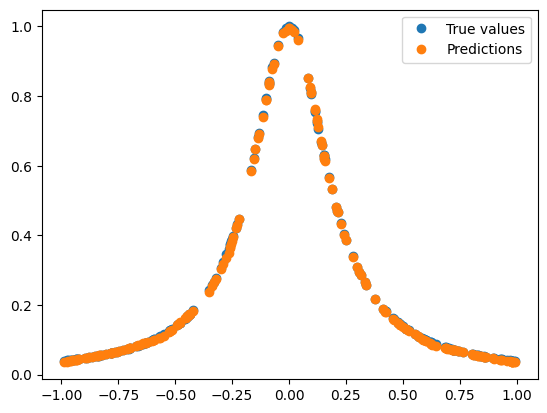

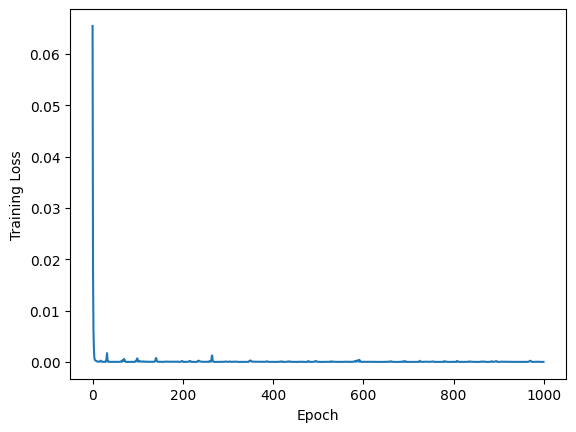

In [62]:
train_dataset_q1_rand, test_dataset_q1_rand = create_dataset( np.random.uniform(-1, 1, num_samples).reshape(-1, 1) ,f_q1)

train_loader_q1_rand = DataLoader(train_dataset_q1_rand, batch_size=32)
test_loader_q1_rand = DataLoader(test_dataset_q1_rand, batch_size=32)

net_q1_rand = Net_general(1,50,2)
criterion_q1_rand = nn.MSELoss()
optimizer_q1_rand = optim.Adam(net_q1_rand.parameters(), lr=0.01)

outputs_q1_rand, train_losses_q1_rand, test_loss_q1_rand = train_and_evaluate(net_q1_rand, criterion_q1_rand, optimizer_q1_rand, train_loader_q1_rand, test_loader_q1_rand)
print('Test loss: %.6f' % test_loss_q1_rand)

plot_losses_and_predictions(test_dataset_q1_rand, train_losses_q1_rand, outputs_q1_rand)

# Q2 Chebyshev sampling

Test Loss: 0.000


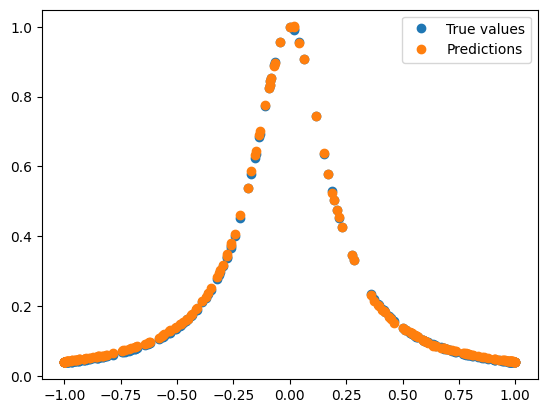

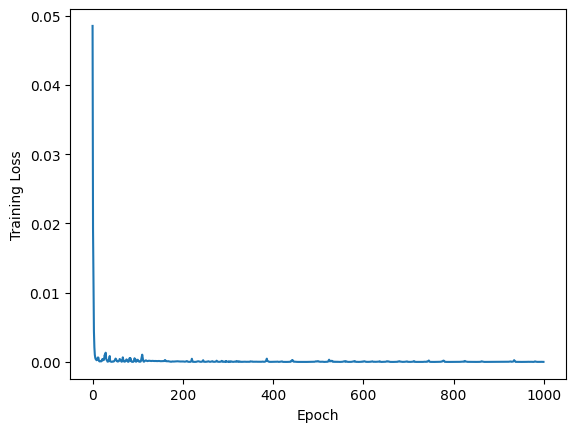

In [63]:
train_dataset_q1_cheb, test_dataset_q1_cheb = create_dataset( np.cos((2 * np.arange(1, num_samples + 1) - 1) * np.pi / (2 * num_samples)).reshape(-1, 1) ,f_q1)

train_loader_q1_cheb = DataLoader(train_dataset_q1_cheb, batch_size=32)
test_loader_q1_cheb = DataLoader(test_dataset_q1_cheb, batch_size=32)

net_q1_cheb = Net_general(1,50,2)
criterion_q1_cheb = nn.MSELoss()
optimizer_q1_cheb = optim.Adam(net_q1_cheb.parameters(), lr=0.01)

outputs_q1_cheb, train_losses_q1_cheb, test_loss_q1_cheb = train_and_evaluate(net_q1_cheb, criterion_q1_cheb, optimizer_q1_cheb, train_loader_q1_cheb, test_loader_q1_cheb)
print('Test loss: %.6f' % test_loss_q1_cheb)

plot_losses_and_predictions(test_dataset_q1_cheb, train_losses_q1_cheb, outputs_q1_cheb)

# Q3: Attached at the end and as a separate .ipynb file

# Q4: Neural network approximation of hat function

In [65]:
def hat_fn(x):
    '''The hat function for question 2.'''
    y_hat = 1.0 - np.abs(x)/(np.pi/2)
    y_hat[np.abs(x) > np.pi/2] = 0
    return y_hat

In [69]:
train_dataset_hat, test_dataset_hat = create_dataset( np.random.uniform(-np.pi, np.pi, num_samples).reshape(-1, 1) , hat_fn)

train_loader_hat = DataLoader(train_dataset_hat, batch_size=32)
test_loader_hat = DataLoader(test_dataset_hat, batch_size=32)

Test Loss: 0.000


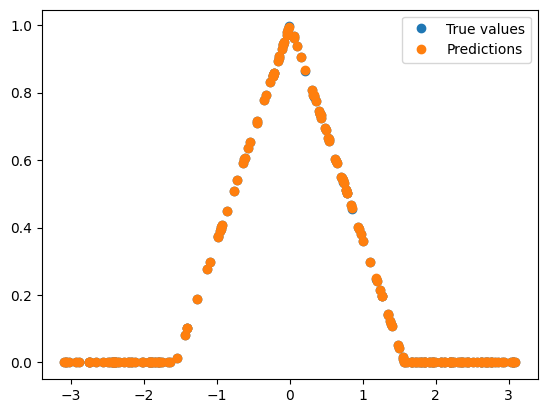

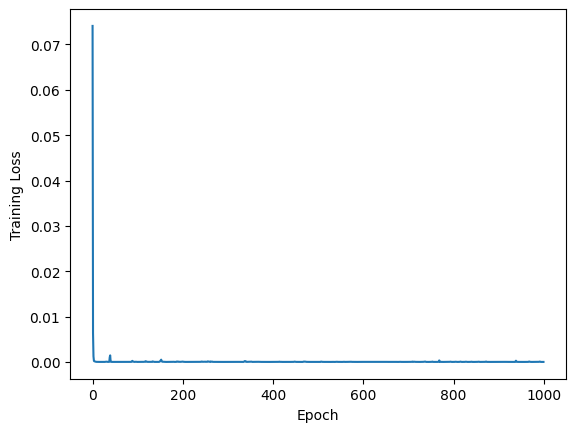

In [70]:
net_q4 = Net_general(1,50,2)
criterion_q4 = nn.MSELoss()
optimizer_q4 = optim.Adam(net_q4.parameters(), lr=0.01)

outputs_q4_hat, train_losses_q4_hat, test_loss_q4_hat = train_and_evaluate(net_q4, criterion_q4, optimizer_q4, train_loader_hat, test_loader_hat)
print('Test loss: %.6f' % test_loss_q4_hat)

plot_losses_and_predictions(test_dataset_hat, train_losses_q4_hat, outputs_q4_hat)

# Q5: Fourier series expansion of f(x)

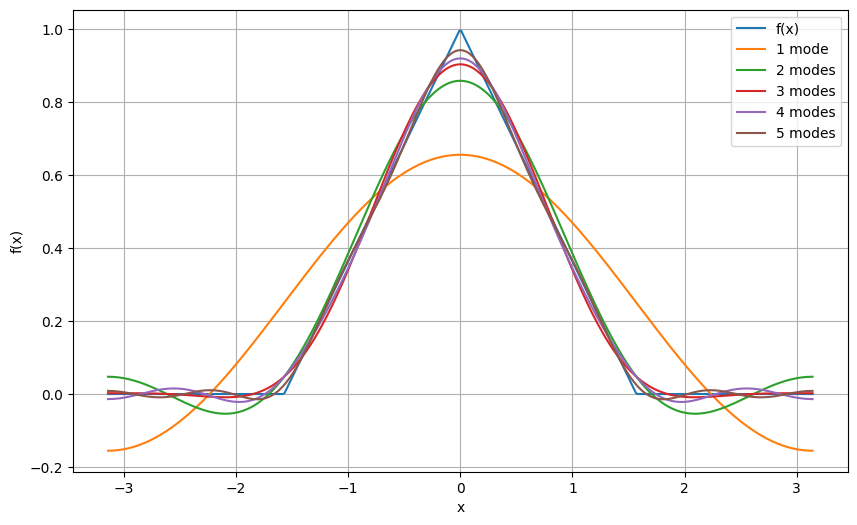

In [22]:
x = sp.symbols('x')
f = sp.Piecewise((1.0 - sp.Abs(x)/(sp.pi/2), sp.Abs(x) < sp.pi/2), (0, True))

F = sp.fourier_series(f, (x, -sp.pi, sp.pi))

f_np = sp.lambdify(x, f, 'numpy')
F_1 = sp.lambdify(x, F.truncate(n=2), 'numpy')
F_2 = sp.lambdify(x, F.truncate(n=3), 'numpy')
F_3 = sp.lambdify(x, F.truncate(n=4), 'numpy')
F_4 = sp.lambdify(x, F.truncate(n=5), 'numpy')
F_5 = sp.lambdify(x, F.truncate(n=6), 'numpy')

x_vals = np.linspace(-np.pi, np.pi, 400)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, f_np(x_vals), label='f(x)')
plt.plot(x_vals, F_1(x_vals), label='1 mode')
plt.plot(x_vals, F_2(x_vals), label='2 modes')
plt.plot(x_vals, F_3(x_vals), label='3 modes')
plt.plot(x_vals, F_4(x_vals), label='4 modes')
plt.plot(x_vals, F_5(x_vals), label='5 modes')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.title('Fourier Series of f(x)')
plt.grid(True)
plt.show()

# Q6: Accuracy with increasing neurons and number of hidden layers

Test Loss: 0.000002
R2 Score: 0.999983
Hidden neurons: 10, Num. layers: 1, Test Loss: 0.000002


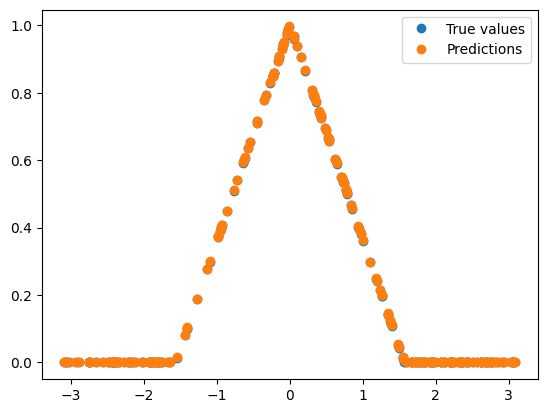

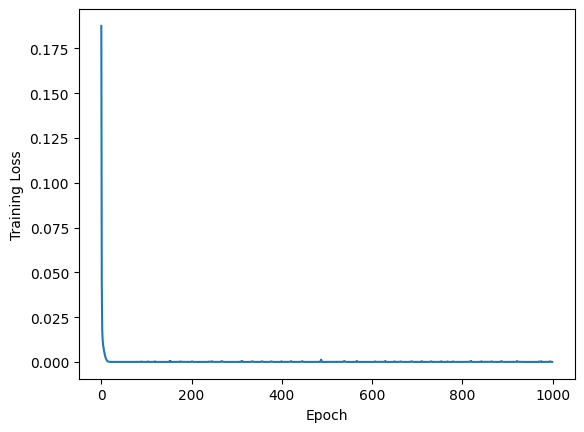

Test Loss: 0.000002
R2 Score: 0.999980
Hidden neurons: 10, Num. layers: 2, Test Loss: 0.000002


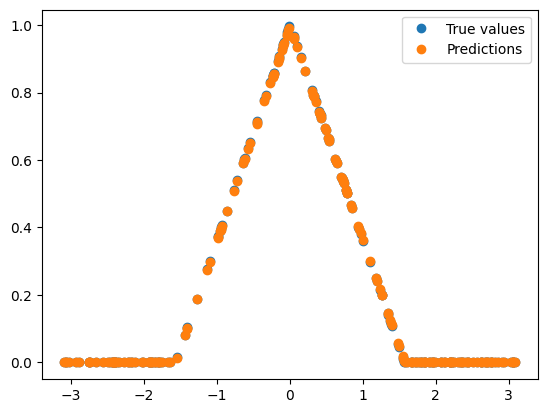

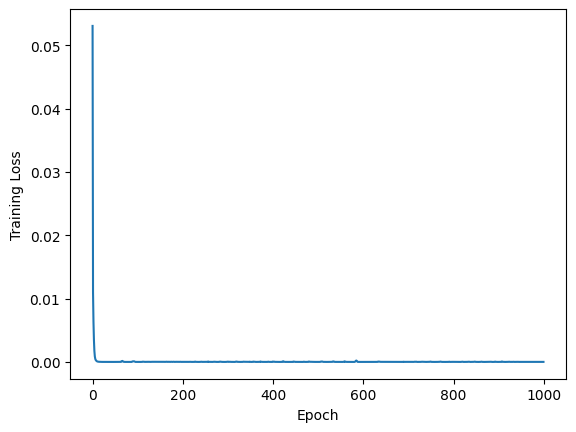

Test Loss: 0.000101
R2 Score: 0.999172
Hidden neurons: 10, Num. layers: 3, Test Loss: 0.000101


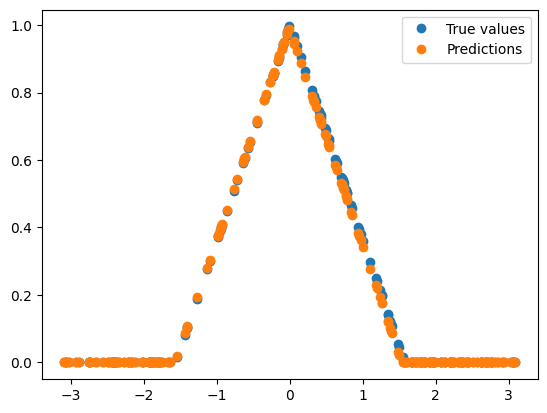

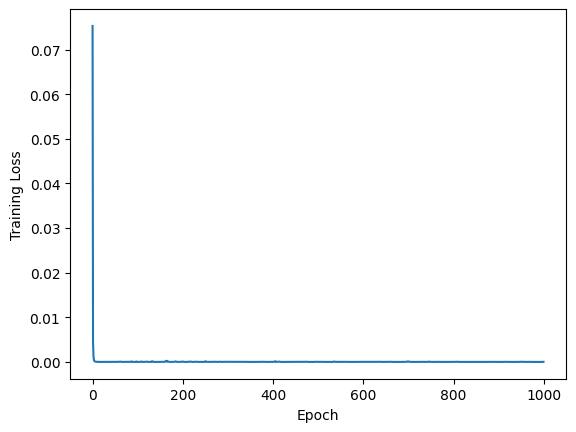

Test Loss: 0.000001
R2 Score: 0.999993
Hidden neurons: 20, Num. layers: 1, Test Loss: 0.000001


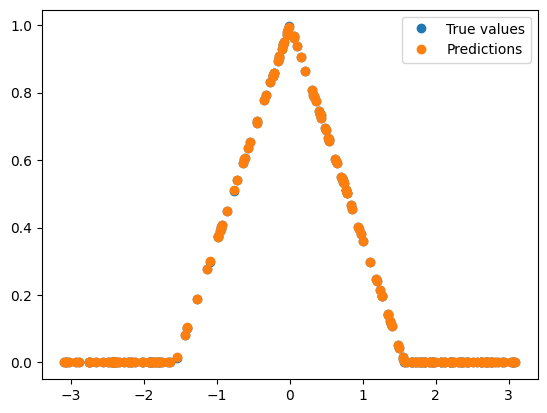

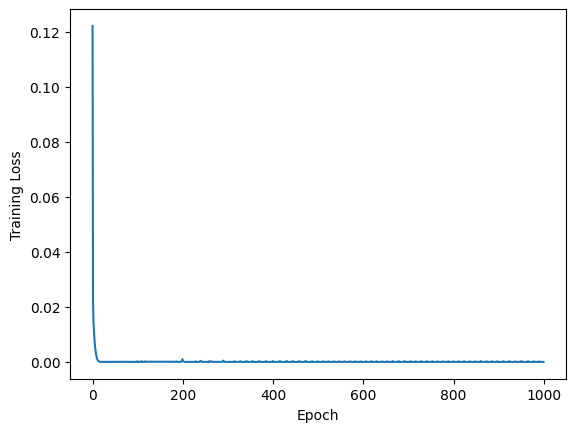

Test Loss: 0.000005
R2 Score: 0.999963
Hidden neurons: 20, Num. layers: 2, Test Loss: 0.000005


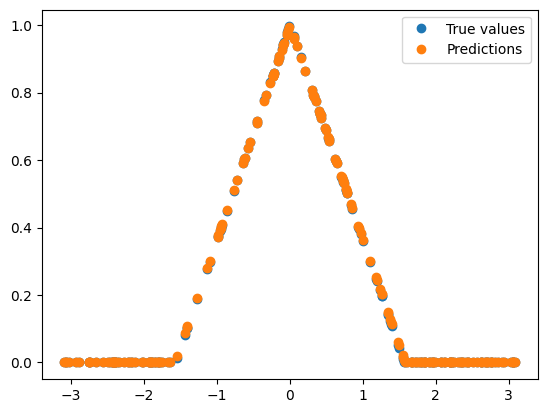

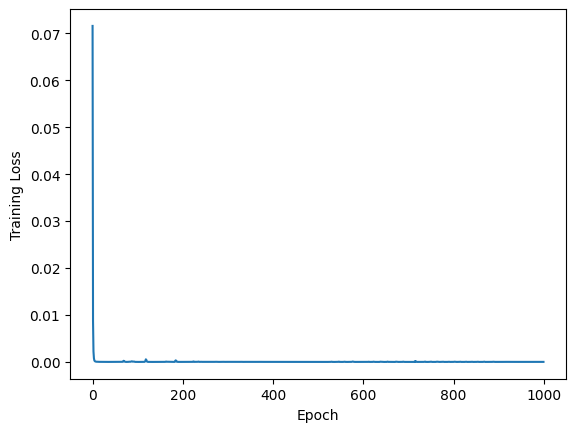

Test Loss: 0.000002
R2 Score: 0.999985
Hidden neurons: 20, Num. layers: 3, Test Loss: 0.000002


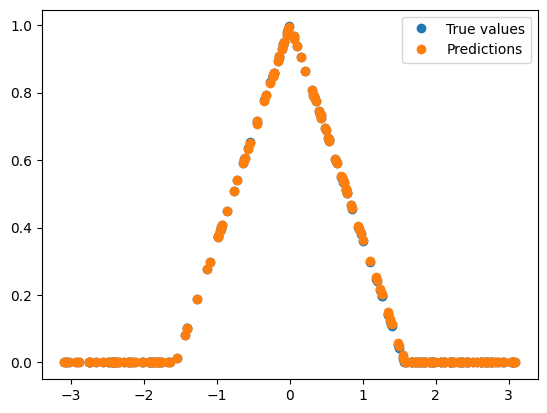

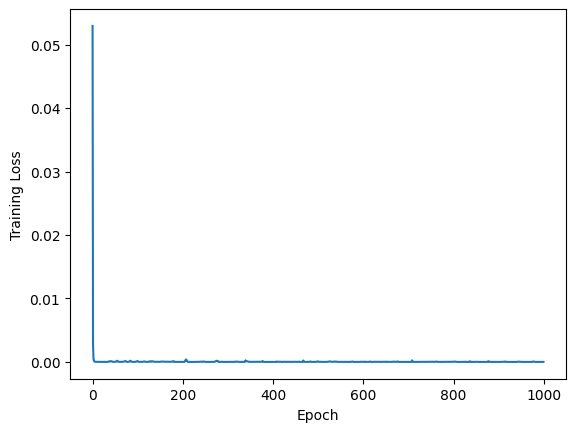

Test Loss: 0.000000
R2 Score: 0.999998
Hidden neurons: 50, Num. layers: 1, Test Loss: 0.000000


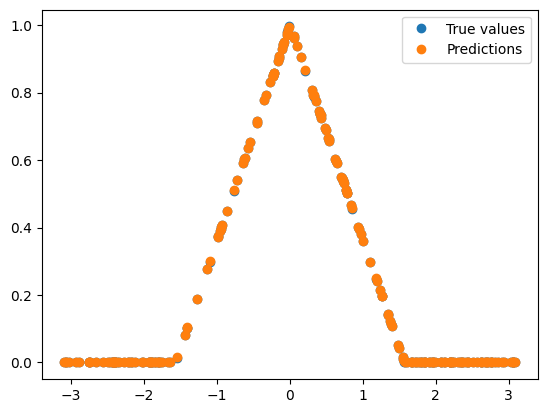

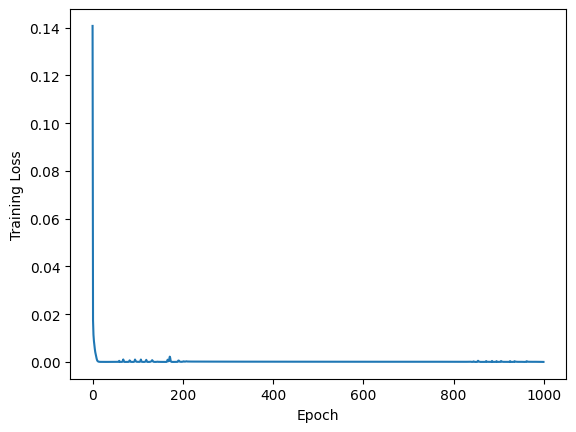

Test Loss: 0.000015
R2 Score: 0.999886
Hidden neurons: 50, Num. layers: 2, Test Loss: 0.000015


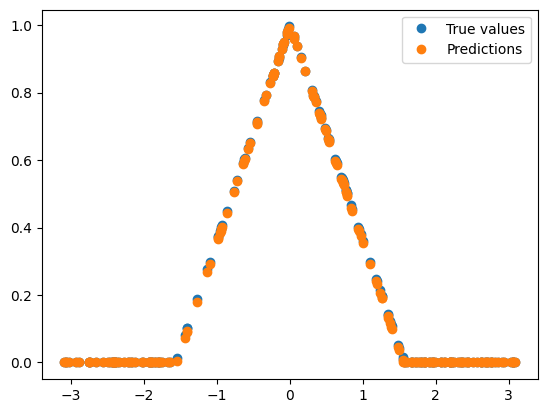

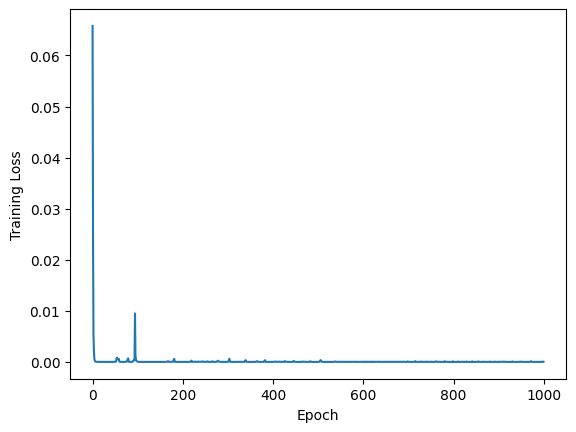

Test Loss: 0.000007
R2 Score: 0.999950
Hidden neurons: 50, Num. layers: 3, Test Loss: 0.000007


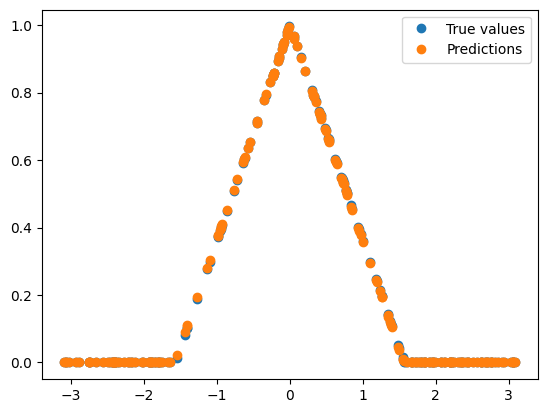

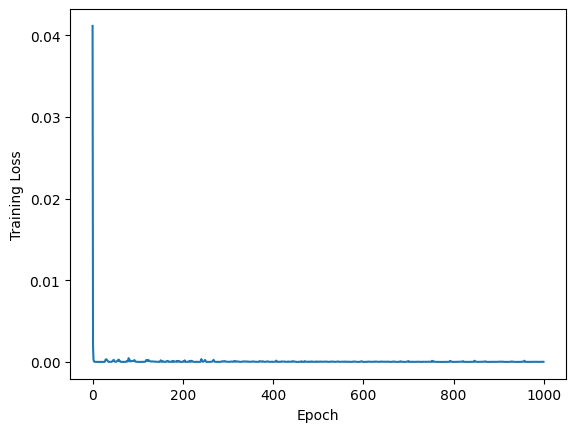

Test Loss: 0.000099
R2 Score: 0.999197
Hidden neurons: 100, Num. layers: 1, Test Loss: 0.000099


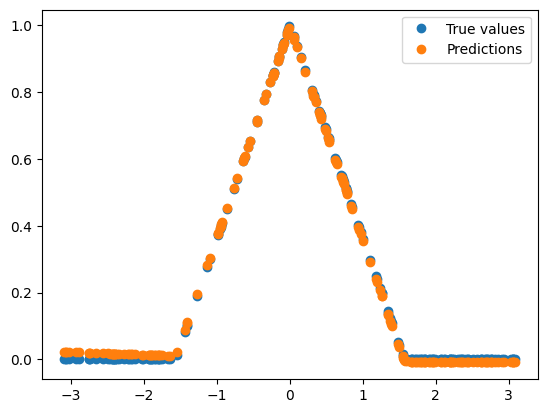

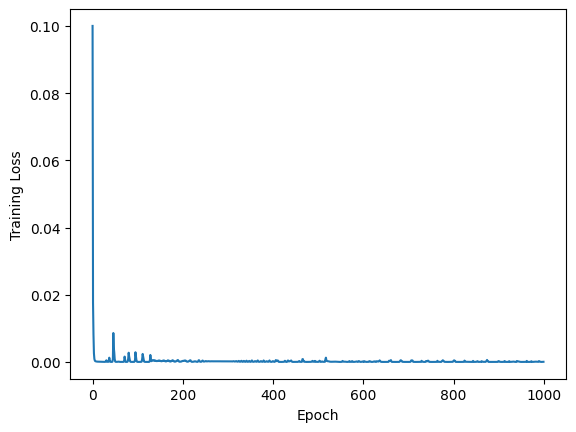

Test Loss: 0.000000
R2 Score: 1.000000
Hidden neurons: 100, Num. layers: 2, Test Loss: 0.000000


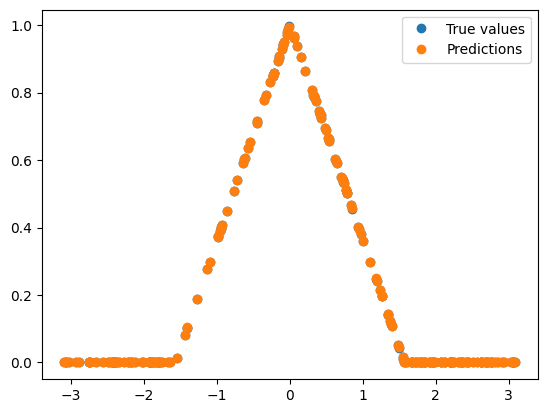

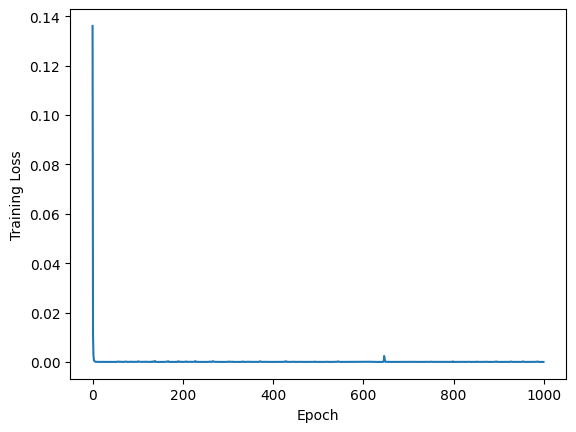

Test Loss: 0.000032
R2 Score: 0.999751
Hidden neurons: 100, Num. layers: 3, Test Loss: 0.000032


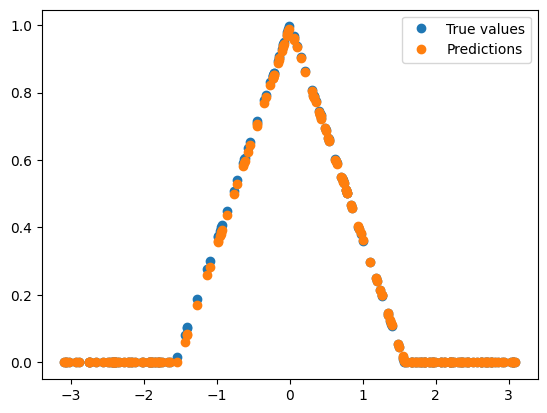

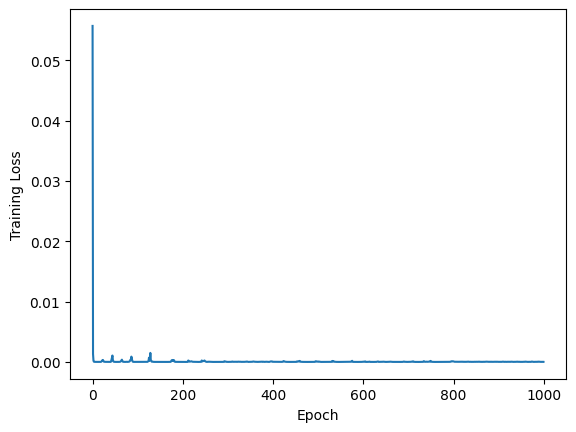

In [195]:
for hidden_neurons in [10, 20, 50, 100]:
    for num_layers in [1, 2, 3]:
        n = Net_general(1, hidden_neurons, num_layers)
        c = nn.MSELoss()
        o = optim.Adam(n.parameters(), lr=0.01)
        preds, train_losses, test_loss = train_and_evaluate(n, c, o, train_loader_hat, test_loader_hat)
        
        print(f'Hidden neurons: {hidden_neurons}, Num. layers: {num_layers}, Test Loss: {test_loss:.6f}')
        # plt.plot(train_losses, label=f'Hidden size: {hidden_neurons}, Num layers: {num_layers}')
        plot_losses_and_predictions(test_dataset_hat, train_losses, preds)
        

As the number of neurons in the hidden layers increases, the test loss decreases. It is also observed that the R2 score for the models also increases as the number of neurons increases. 

# Q7:

Similarity:
Both neural networks and Fourier series are methods of approximating any complex function. They can both be looked at as a linear combination of different basis functions. In the Fourier series, the basis functions are sin(kx) and cos(kx). In the neural network, the basis functions are activation functions of the neurons. In both methods, the coefficients are determined by fitting the data to the model. 

Differences:
-In Fourier series, the sinusoidal basis functions are fixed and predefined, whereas, in the neural network the basis functions are learned by the model during training. With a flexible basis, neural networks are more flexible and can be used to learn more complex functions than Fourier series approximation can.
-In additon, neural networks introduce non-linearity through activation functions, as compared to Fourier series that are inherently linear. 
-Fourier series basis functions are global. In contrast, neural networks have local basis/activation functions and the changes to the network are more localized.

# Q8:

In [151]:
class NN_q8(nn.Module):
    def __init__(self, num_neurons_last_layer, num_layers=2, hidden_size=50, input_size=1):
        super(NN_q8, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, num_neurons_last_layer))
        self.layers.append(nn.Linear(num_neurons_last_layer, 1))

    def forward(self, x, activations=False):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == len(self.layers) - 2 and activations:  # If this is the last hidden layer and activations=True
                return x
            x = torch.relu(x)
        return x

Test Loss: 5.881685
torch.Size([200, 1])


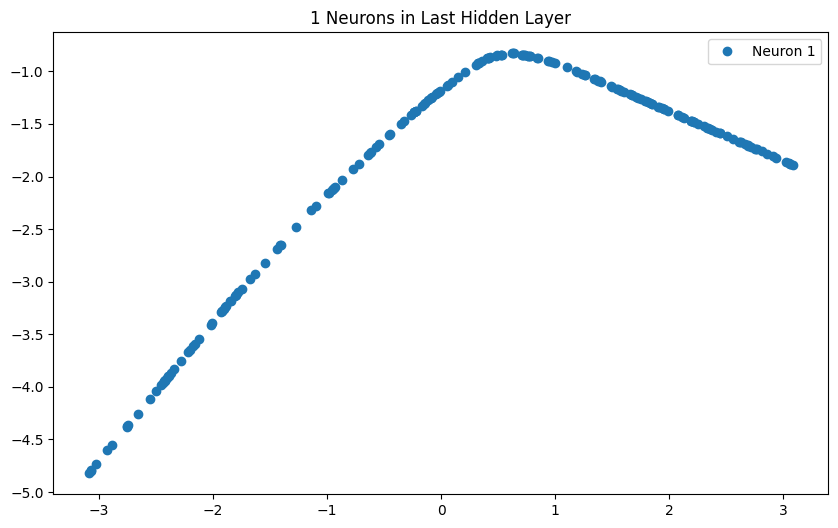

Test Loss: 0.292641
torch.Size([200, 2])


/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


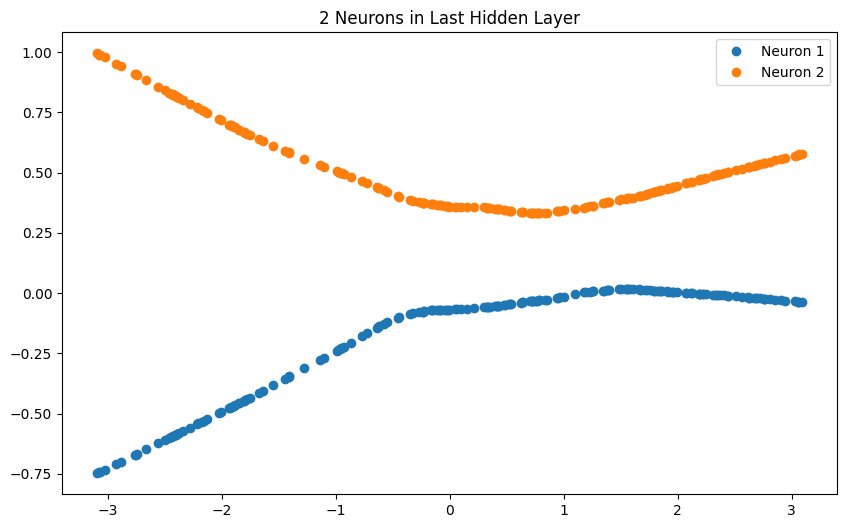

Test Loss: 7.100335
torch.Size([200, 3])


/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


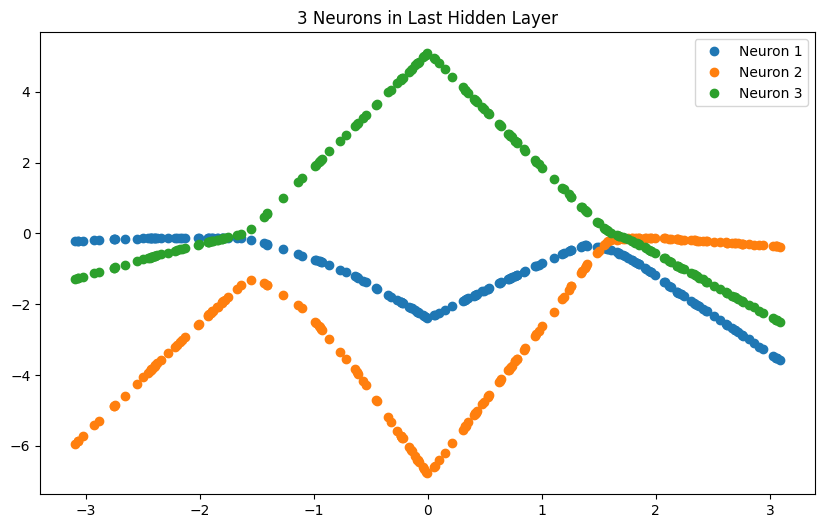

Test Loss: 8.906102
torch.Size([200, 4])


/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


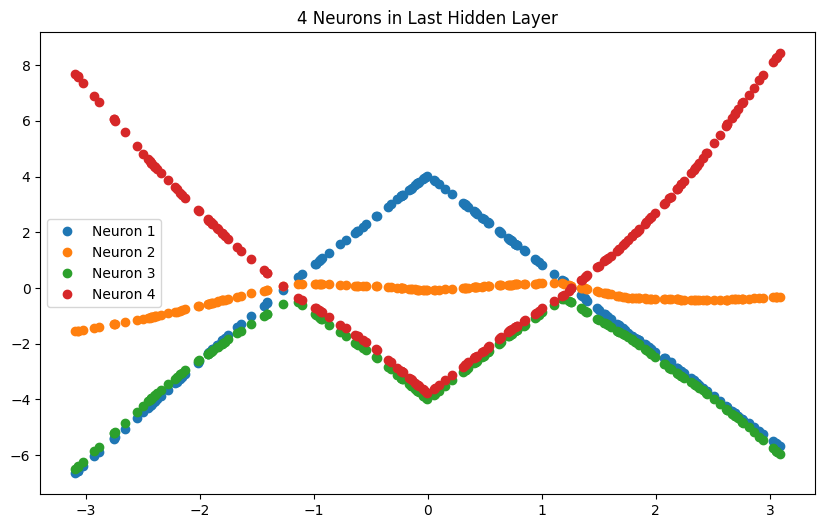

Test Loss: 7.273729
torch.Size([200, 5])


/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


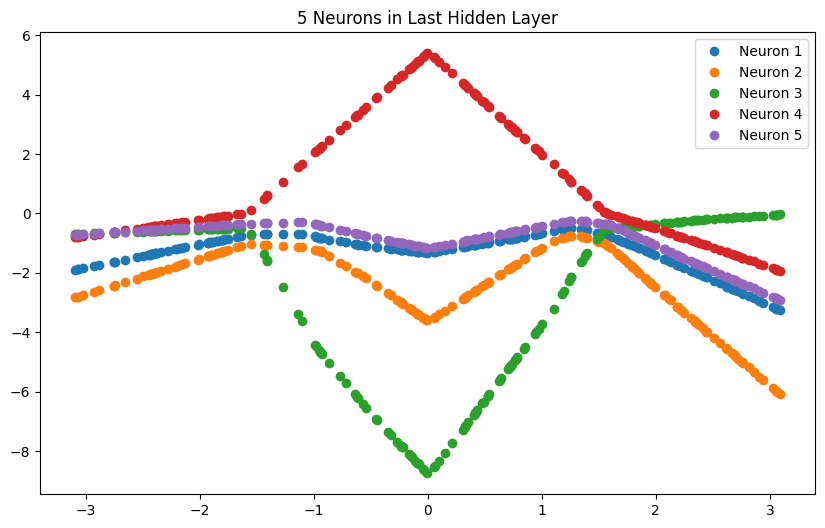

Test Loss: 0.174286
torch.Size([200, 6])


/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


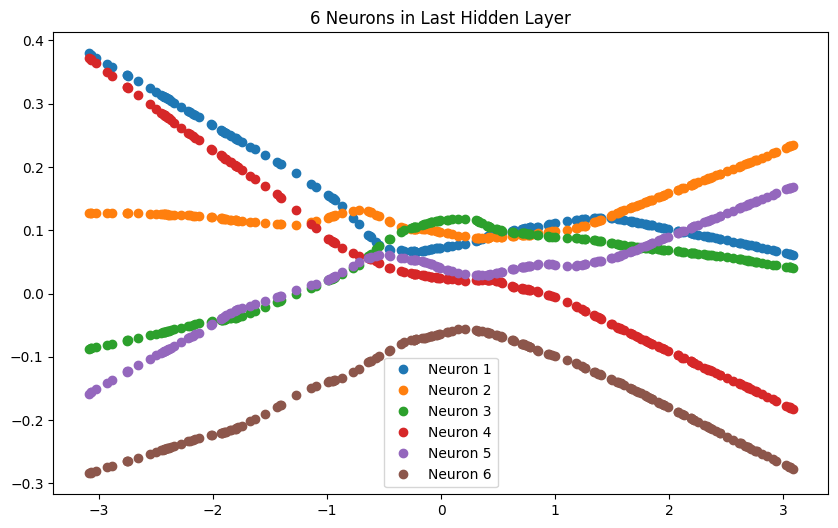

Test Loss: 0.200209
torch.Size([200, 7])


/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


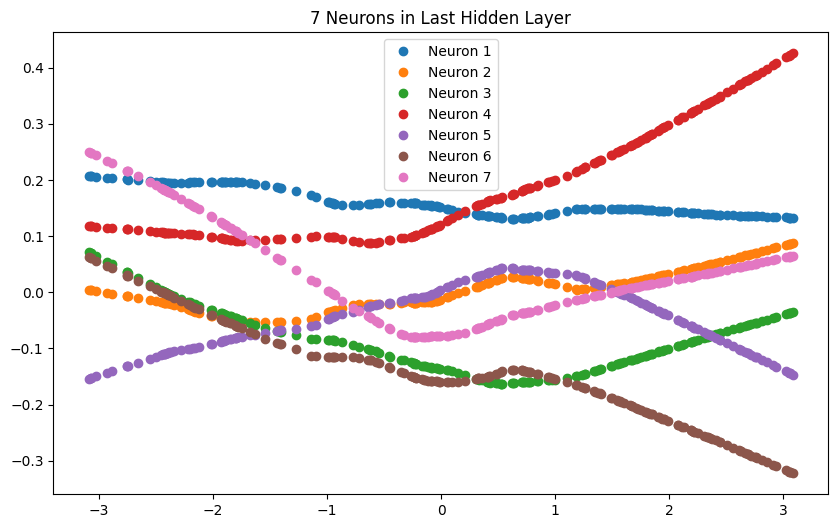

Test Loss: 4.434798
torch.Size([200, 8])


/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/purnavindhyakota/miniconda3/envs/bnn_trials/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


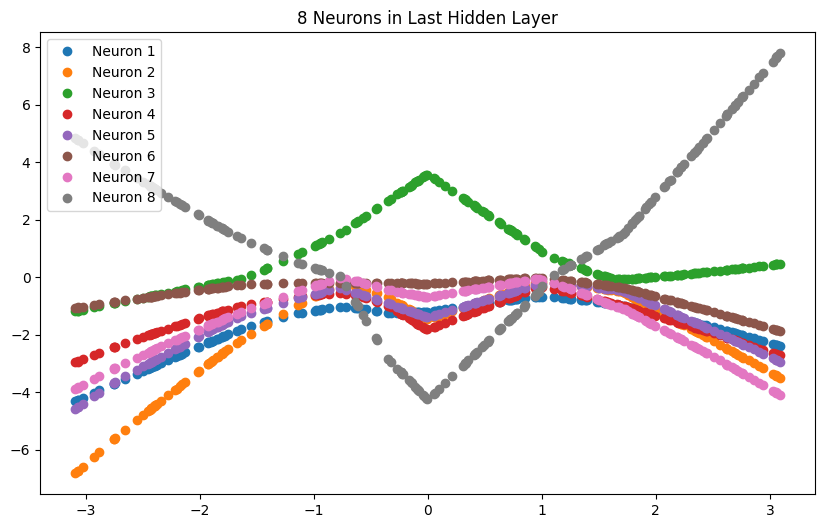

In [191]:
def create_model(num_neurons):
    model = NN_q8(num_neurons_last_layer=num_neurons, num_layers=2, hidden_size=50, input_size=1)
    return model

# models = []
for i in range(1, 9):
    model = create_model(i)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = torch.nn.MSELoss()
    act_last, _, _ = train_and_evaluate(model, criterion, optimizer, train_loader_hat, test_loader_hat, activations=True)
    print(act_last.shape)
    plt.figure(figsize=(10, 6))
    for j in range(act_last.shape[1]):
        plt.plot(test_dataset_hat.tensors[0].numpy(), act_last[:, j].numpy(), 'o' ,label=f'Neuron {j+1}')
    plt.title(f'{i} Neurons in Last Hidden Layer')
    plt.legend()
    plt.show()

# Q9

## (i)

In [160]:
def fn_q9(x):
    return np.where(x < 0, 5 + np.sum([np.sin(k * x) for k in range(1, 7)], axis=0), np.cos(10 * x))

In [161]:
train_dataset_q9_i, test_dataset_q9_i = create_dataset(np.random.uniform(-np.pi, np.pi, num_samples).reshape(-1, 1), fn_q9)

train_loader_q9_i = DataLoader(train_dataset_q9_i, batch_size=32)
test_loader_q9_i = DataLoader(test_dataset_q9_i, batch_size=32)

In [162]:
optimizers_all = {
    'Adam': lambda net: torch.optim.Adam(net.parameters(), lr=0.01),
    'SGD': lambda net: torch.optim.SGD(net.parameters(), lr=0.01),
    'RMSprop': lambda net: torch.optim.RMSprop(net.parameters(), lr=0.01),
    'Adagrad': lambda net: torch.optim.Adagrad(net.parameters(), lr=0.01),
    'Rprop': lambda net: torch.optim.RMSprop(net.parameters(), lr=0.01),
    'AdaHessian': lambda net: torch_optimizer.Adahessian(
    net.parameters(),
    lr= 0.7,
    betas= (0.9, 0.999),
    eps= 1e-4,
    weight_decay=0.0,
    hessian_power=1.0,
)
}


Test Loss: 0.069174
Optimizer: Adam, Test Loss: 0.069174


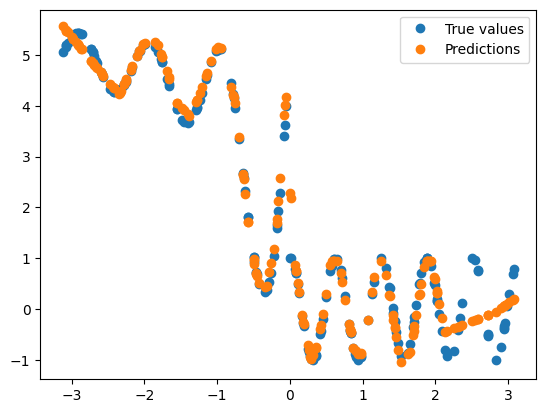

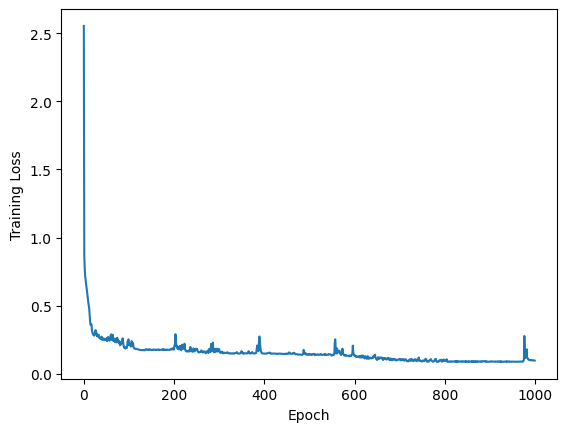

Test Loss: nan
Optimizer: SGD, Test Loss: nan


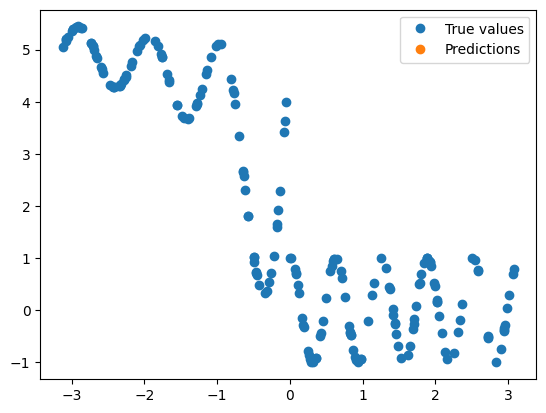

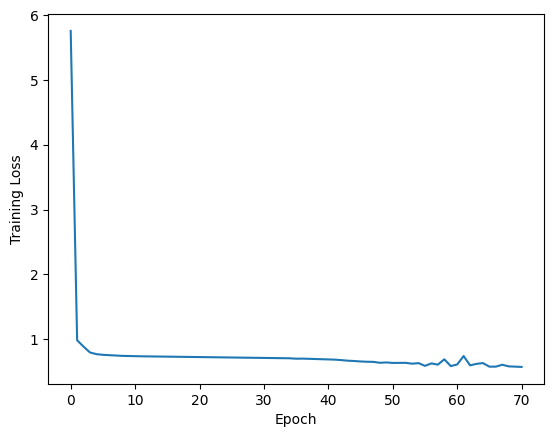

Test Loss: 0.226039
Optimizer: RMSprop, Test Loss: 0.226039


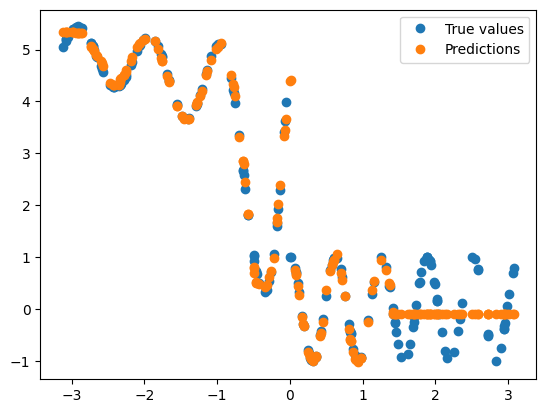

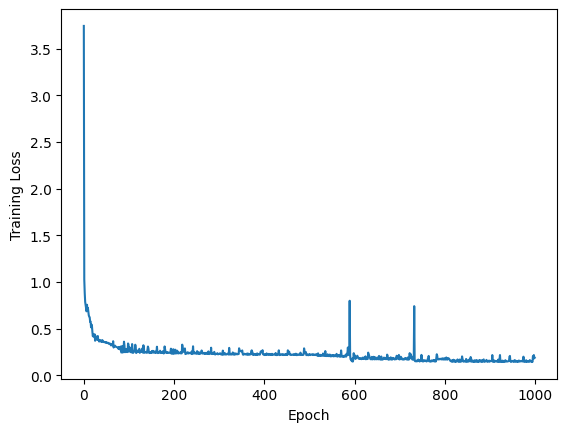

Test Loss: 0.121742
Optimizer: Adagrad, Test Loss: 0.121742


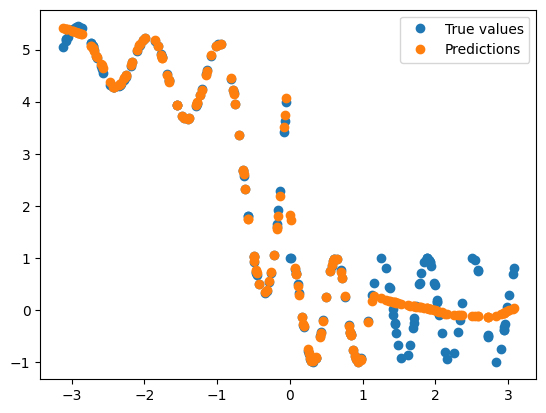

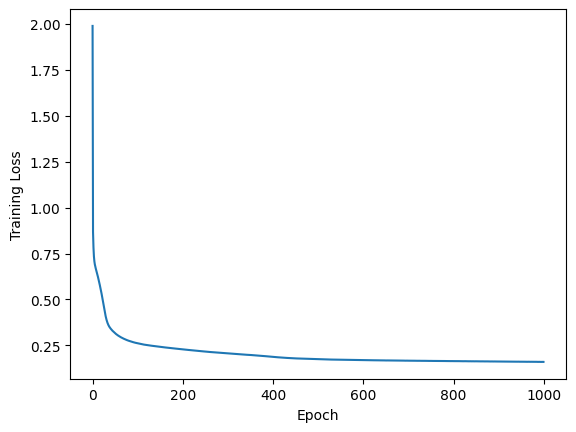

Test Loss: 0.171960
Optimizer: Rprop, Test Loss: 0.171960


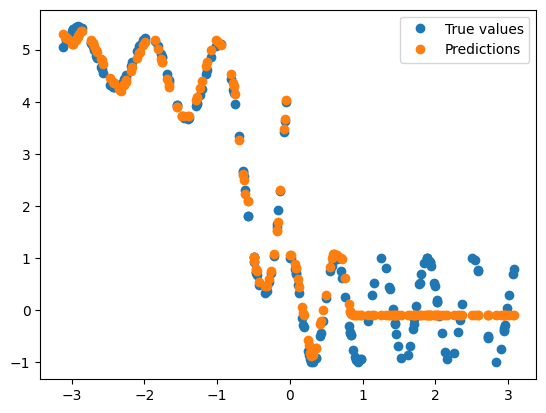

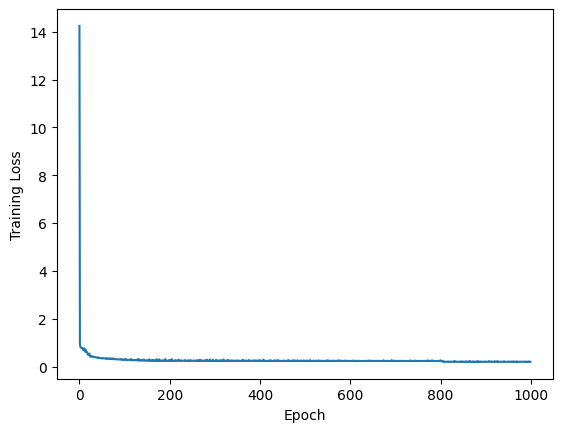

Test Loss: 0.074262
Optimizer: AdaHessian, Test Loss: 0.074262


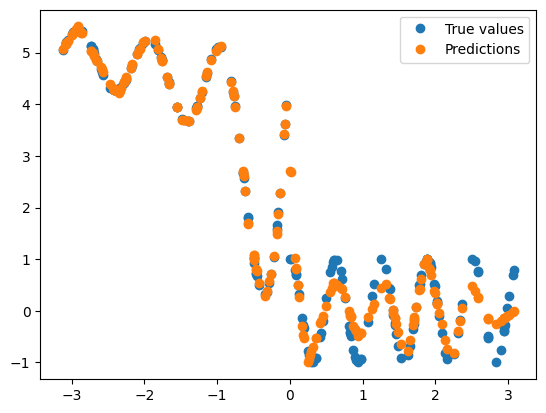

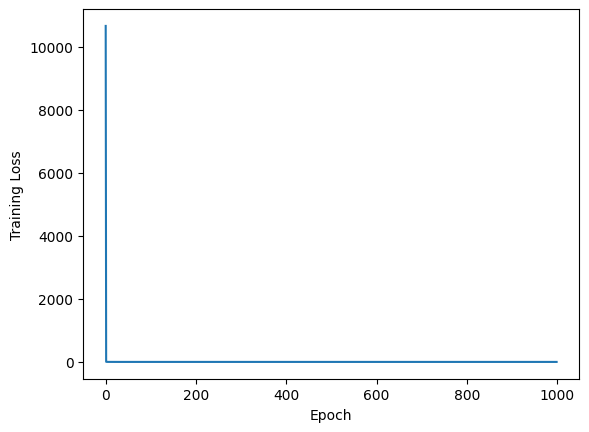

In [163]:
for name, optimizer in optimizers_all.items():
    n = Net_general(1, 50, 4)
    c = nn.MSELoss()
    o = optimizer(n)
    preds, train_losses, test_loss = train_and_evaluate( n, c, o, train_loader_q9_i, test_loader_q9_i)
    print(f'Optimizer: {name}, Test Loss: {test_loss:.6f}')
    plot_losses_and_predictions(test_dataset_q9_i, train_losses, preds)

## (ii)

In [172]:
def fn_q9_ii(x):
    return np.where(x < 1.0, 0, 1)

In [173]:
train_dataset_q9_ii, test_dataset_q9_ii = create_dataset(np.random.uniform(-2, 2, num_samples).reshape(-1, 1), fn_q9_ii)

train_loader_q9_ii = DataLoader(train_dataset_q9_ii, batch_size=32)
test_loader_q9_ii = DataLoader(test_dataset_q9_ii, batch_size=32)

In [189]:
optimizers_all_ii = {
    'Adam': lambda net: torch.optim.Adam(net.parameters(), lr=0.01),
    'SGD': lambda net: torch.optim.SGD(net.parameters(), lr=0.01),
    'RMSprop': lambda net: torch.optim.RMSprop(net.parameters(), lr=0.01),
    'Adagrad': lambda net: torch.optim.Adagrad(net.parameters(), lr=0.1),
    'Rprop': lambda net: torch.optim.RMSprop(net.parameters(), lr=0.002),
    'LBFGS': optim.LBFGS,
    'AdaHessian': lambda net: torch_optimizer.Adahessian(
    net.parameters(),
    lr= 0.01,
    betas= (0.9, 0.999),
    eps= 1e-4,
    weight_decay=1e-3,
    hessian_power=1.0,
)
}

Test Loss: 0.000968
Optimizer: Adam, Test Loss: 0.000968


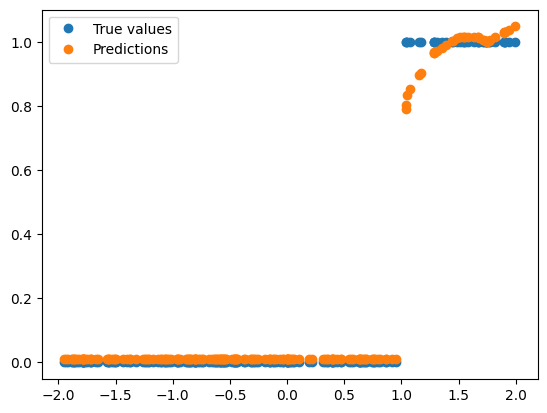

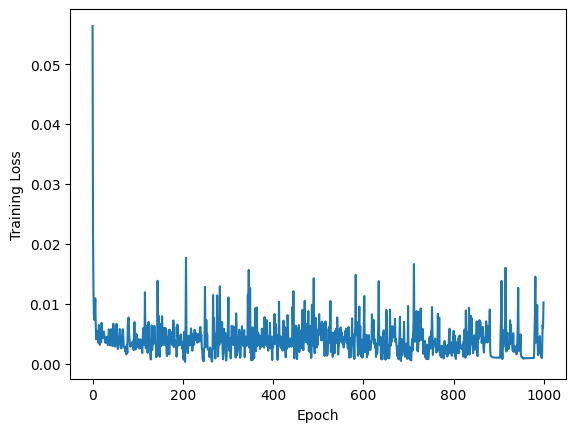

Test Loss: 0.000155
Optimizer: SGD, Test Loss: 0.000155


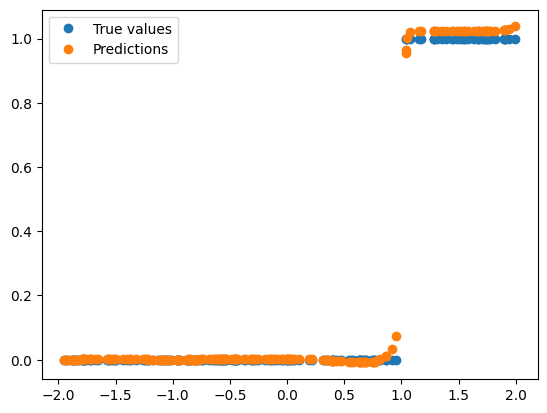

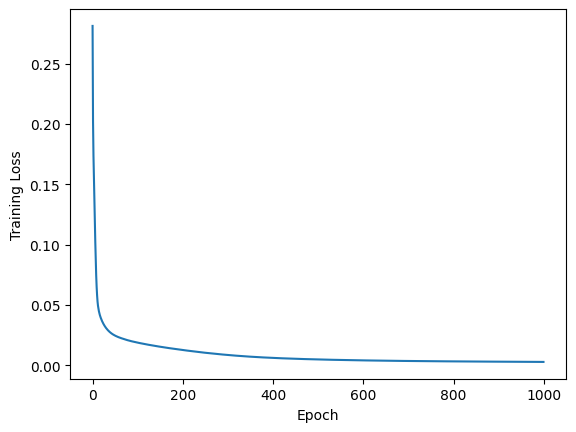

Test Loss: 0.000245
Optimizer: RMSprop, Test Loss: 0.000245


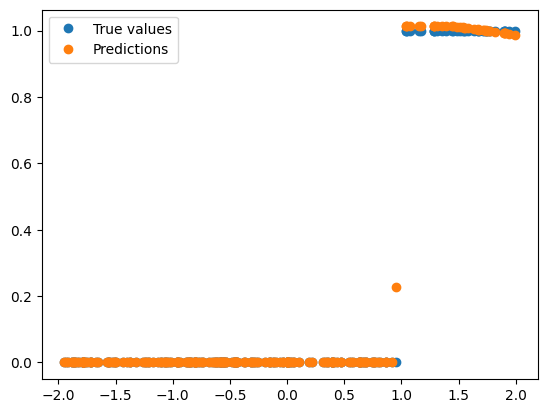

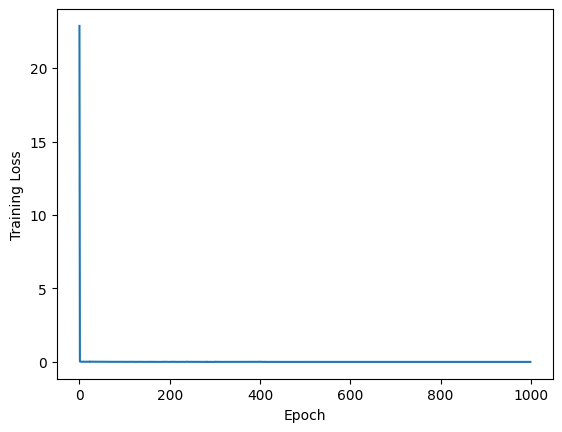

Test Loss: 0.000066
Optimizer: Adagrad, Test Loss: 0.000066


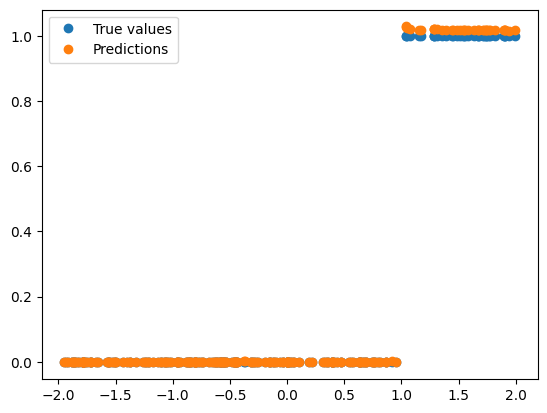

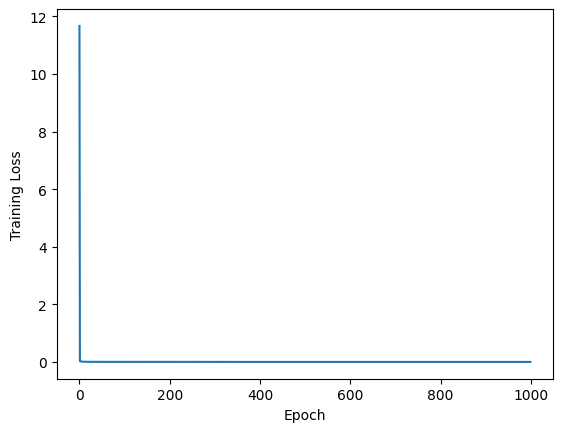

Test Loss: 0.000024
Optimizer: Rprop, Test Loss: 0.000024


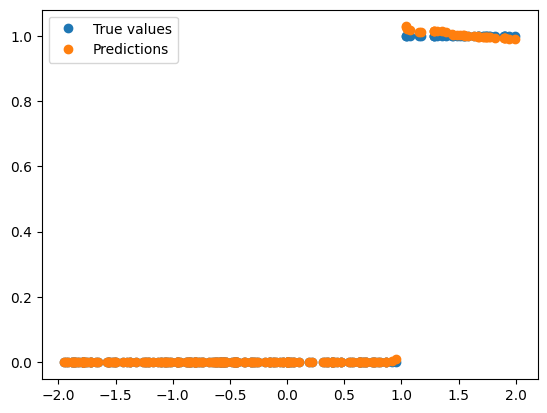

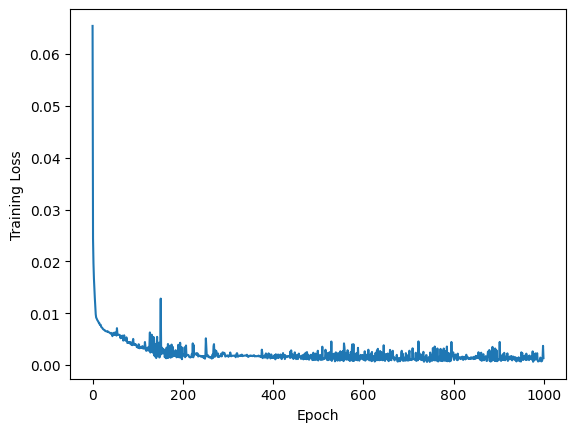

TypeError: 'Net_general' object is not iterable

In [190]:
for name, optimizer in optimizers_all_ii.items():
    n = Net_general(1, 50, 4)
    c = nn.MSELoss()
    o = optimizer(n)
    preds, train_losses, test_loss = train_and_evaluate( n, c, o, train_loader_q9_ii, test_loader_q9_ii)
    print(f'Optimizer: {name}, Test Loss: {test_loss:.6f}')
    # print(name)
    plot_losses_and_predictions(test_dataset_q9_ii, train_losses, preds)

# Q10

## 1D

In [99]:
def fn_q10(x):
    return x**2

In [259]:
train_dataset_q10, test_dataset_q10 = create_dataset(np.random.uniform(-1, 1, num_samples).reshape(-1, 1), fn_q10)

train_loader_q10 = DataLoader(train_dataset_q10, batch_size=16)
test_loader_q10 = DataLoader(test_dataset_q10, batch_size=16)

Test Loss: 0.000049
R2 Score: 0.999491
Test Loss: 0.000049


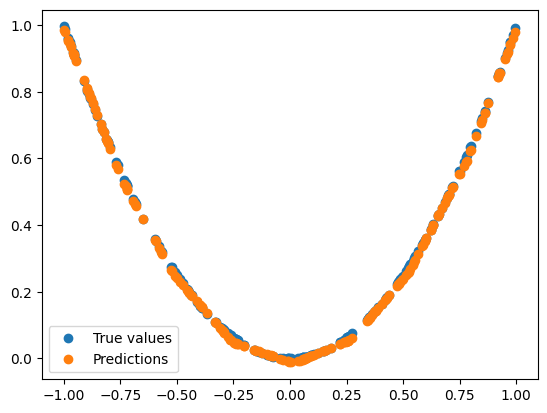

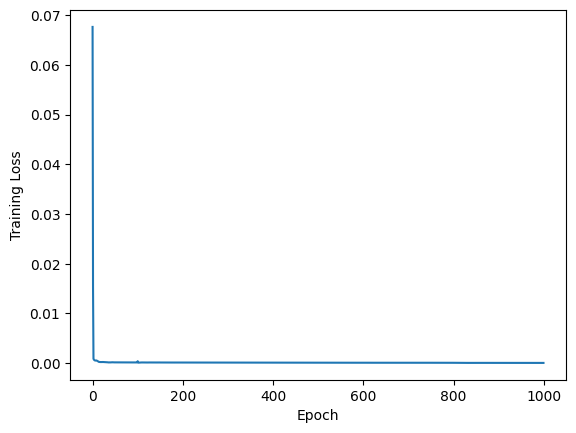

In [260]:
net_q10 = Net_general(1, 5, 2)
criterion_q10 = nn.MSELoss()
optimizer_q10 = torch.optim.Adam(net_q10.parameters(), lr=0.01)
outputs_q10, train_losses_q10, test_losses_q10 = train_and_evaluate(optimizer= optimizer_q10, net= net_q10, criterion= criterion_q10, train_loader= train_loader_q10, test_loader= test_loader_q10)

# Plot the test predictions vs true values
print(f'Test Loss: {test_losses_q10:.6f}')
plot_losses_and_predictions(test_dataset_q10, train_losses_q10, outputs_q10)

In [345]:
def get_direction_vector(net):
    directions=[torch.randn(w.size()) for w in net.parameters()]
    directions_dict={name:direction.to(device) for name, direction in zip(dict(net.named_parameters()).keys(), directions)}
    for (name, direction),param in zip(directions_dict.items(), net.named_parameters()):
        if "bias" in name:
            directions_dict[name] = param[1]
            continue
        direction = direction / torch.norm(direction, dim=1, keepdim=True)*torch.norm(param[1], dim=1, keepdim=True)
        directions_dict[name] = direction
    directions_vec = torch.cat([v.flatten() for v in directions_dict.values()])
    return directions_vec


In [ ]:
params_learnt_q10 = Params2Vec(net_q10.parameters())
directions_vec = get_direction_vector(net_q10)

In [ ]:
losses_q10_1d = []
eval_net_q10 = Net_general(1, 5, 4)
criterion_q10 = nn.MSELoss()
test_loss = 0.0
for alpha in torch.arange(-50, 50, 1):
    test_loss = 0.0
    with torch.no_grad():
      for inputs, targets in test_loader_q10:
        Vec2Params( alpha * directions_vec + params_learnt_q10 ,  eval_net_q10.parameters())
        eval_net_q10.eval()
        preds_1d = eval_net_q10(inputs.float())
        loss = criterion_q10(preds_1d, targets)
        test_loss += loss.item()
      losses_q10_1d.append(test_loss)

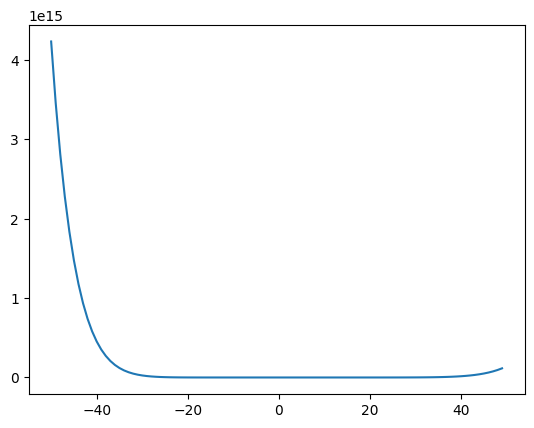

In [255]:
plt.plot(torch.arange(-50, 50, 1), losses_q10_1d)

## 2D

In [ ]:
directions_vec_1 = get_direction_vector(net_q10)
directions_vec_2 = get_direction_vector(net_q10)

### method 1

In [265]:
range_q10_dim_2 = torch.linspace(-20, 20, 10)
alpha, beta = torch.meshgrid(range_q10_dim_2, range_q10_dim_2)

eval_2_net_q10 = Net_general(1, 5, 2)
criterion_q10 = nn.MSELoss()
test_loss = 0.0
losses_q10_dim_2 = []
for i,a in enumerate(alpha.flatten()):
        test_loss = 0.0
        with torch.no_grad():
          for inputs, targets in test_loader_q10:
            Vec2Params(  params_learnt_q10 + a * directions_vec_1 + beta.flatten()[i] * directions_vec_2,  eval_2_net_q10.parameters())
            eval_2_net_q10.eval()
            pred_2d = eval_2_net_q10(inputs)
            loss = criterion_q10(pred_2d, targets)
            test_loss += loss.item()
          losses_q10_dim_2.append(test_loss)

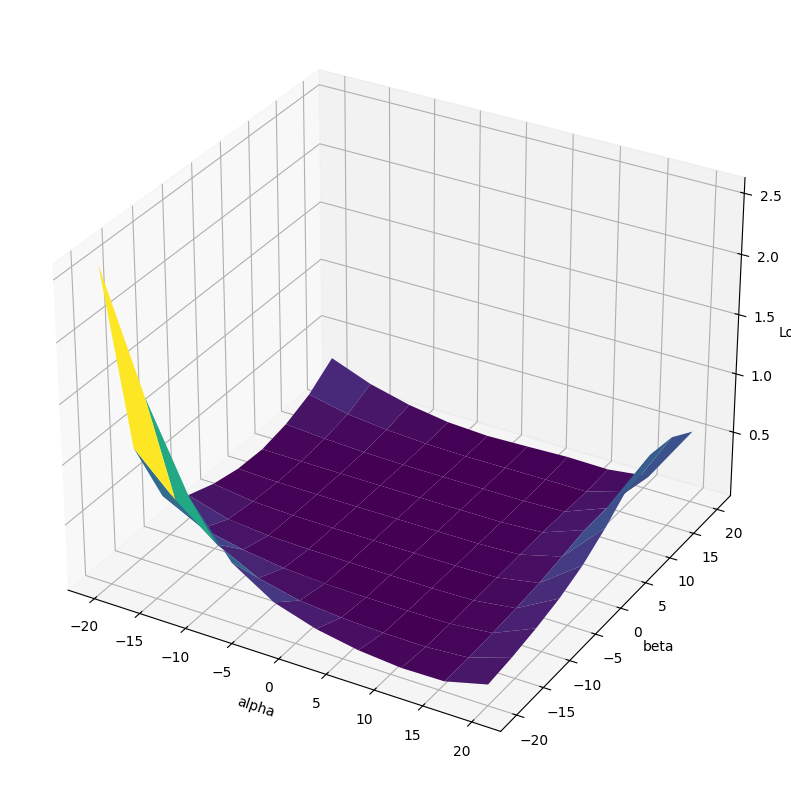

In [266]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha, beta, np.array(losses_q10_dim_2).reshape( alpha.shape ), cmap='viridis')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('Loss')
plt.show()

# Q11

In [364]:
nu = 0.01/np.pi # Viscosity
N_u = 100 # Number of Initial and Boundary data points
N_f = 10000 # Number of residual point
Nmax=  5 #20000


dat = scipy.io.loadmat('./burgers_shock.mat')

t = dat['t'].flatten()[:,None]
x = dat['x'].flatten()[:,None]
Exact = np.real(dat['usol']).T
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]              

X_star = torch.from_numpy(X_star) # t.tensor(X_star).float()
u_star = torch.from_numpy(u_star) # t.tensor(u_star).float()

X_star.requires_grad = True
u_star.requires_grad = True

lb = X_star.min(0)
ub = X_star.max(0)  

xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

xx1= torch.from_numpy(xx1).float() # t.tensor(xx1).float()
uu1= torch.from_numpy(uu1).float() # t.tensor(uu1).float()

xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

xx2= torch.from_numpy(xx2).float() # t.tensor(xx2).float()
uu2= torch.from_numpy(uu2).float() # t.tensor(uu2).float()

xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

xx3= torch.from_numpy(xx3).float() # t.tensor(xx3).float()
uu3= torch.from_numpy(uu3).float() # t.tensor(uu3).float()

In [365]:
def get_derivative(y, x):
    dydx = torch.autograd.grad(
        y, x, torch.ones(x.size()[0], 1), create_graph=True, retain_graph=True
    )[0]

    return dydx

def train_pinn(net, criterion, optimizer, train_loader, num_epochs=100):
    train_losses = []
    net.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            dy_dx = get_derivative(outputs, inputs)
            dy_dx_dx = get_derivative(dy_dx[:,0].reshape(-1,1), inputs)
            op_1 = net(xx1)
            op_2 = net(xx2)
            op_3 = net(xx3)

            loss = criterion( outputs, targets) + \
                    criterion(op_1, uu1) + \
                    criterion(op_2, uu2) + \
                    criterion(op_3, uu3) + \
                    criterion( 
                        ( dy_dx[:,1] + outputs.reshape(-1) * dy_dx[:,0] - (0.1/torch.pi) * dy_dx_dx[:,0] ).reshape(-1,1),
                        torch.zeros( dy_dx[:,0].size()[0], 1 )
                     )
            loss.backward(retain_graph=True)
            optimizer.step()
            epoch_loss += loss.item()
            
        if epoch % 10 == 0:
            print(f'Epoch {epoch} Loss: {epoch_loss}')
        train_losses.append(epoch_loss / len(train_loader))

    return train_losses

def test_pinn(net, criterion, test_loader, activations=False):
    net.eval()
    test_loss = 0
    all_outputs = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = net(inputs, activations=activations)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            all_outputs.append(outputs)
            # all_targets.append(targets)
    test_loss /= len(test_loader)
    # print('Test Loss: %.6f' % test_loss)

    return torch.cat(all_outputs), test_loss
    

In [318]:
def dataset_pinn(x, y, test_size=0.2):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=42)
    train_dataset = TensorDataset(x_train.float(), y_train.float())
    test_dataset = TensorDataset(x_test.float(), y_test.float())

    return train_dataset, test_dataset

In [366]:
def plot_pinn(test_dataset, train_losses, outputs):
    # plt.plot(test_dataset.tensors[0][1].detach().numpy(), test_dataset.tensors[1][1].detach().numpy(), 'o' ,label='True values')
    # plt.plot(test_dataset.tensors[0][1].detach().numpy(), outputs.numpy(), 'o' ,label='Predictions')
    # plt.legend()
    # plt.show()

    plt.figure()
    plt.plot(train_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.show()

In [367]:
train_dataset_q11, test_dataset_q11 = dataset_pinn(X_star, u_star, test_size=0.2)

train_loader_q11 = DataLoader(train_dataset_q11, batch_size=1000)
test_loader_q11 = DataLoader(test_dataset_q11, batch_size=1000)

net_q11 = Net_general(2, 20, 4, activation_function=torch.tanh)
criterion_q11 = nn.MSELoss()
optimizer_q11 = optim.Adam(net_q11.parameters(), lr=0.001)

train_losses_q11 = train_pinn(net_q11, criterion_q11, optimizer_q11, train_loader_q11)


Epoch 0 Loss: 17.235100984573364
Epoch 10 Loss: 4.1388372629880905
Epoch 20 Loss: 2.418226547539234
Epoch 30 Loss: 1.404207732528448
Epoch 40 Loss: 0.9335015937685966
Epoch 50 Loss: 0.7728598304092884
Epoch 60 Loss: 0.6909549459815025
Epoch 70 Loss: 0.6246391832828522
Epoch 80 Loss: 0.5863025430589914
Epoch 90 Loss: 0.5491523705422878


In [334]:
outputs_q11, test_loss_q11 = test_pinn(net_q11, criterion_q11, test_loader_q11)

Test Loss: 0.014295


Test loss: 0.014295


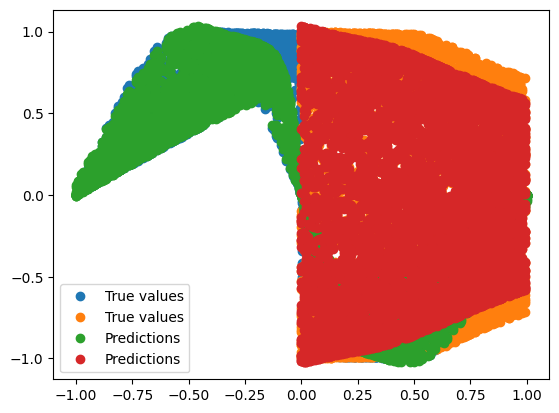

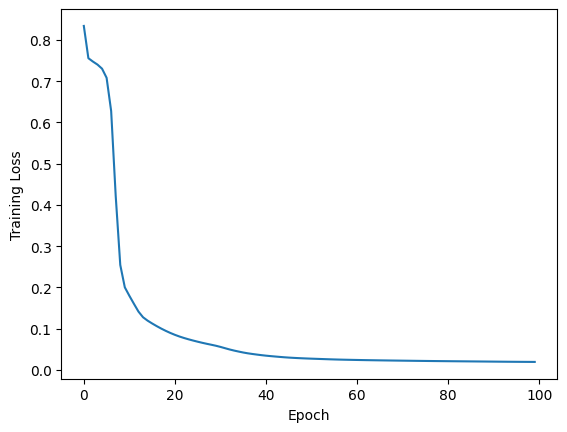

In [335]:
print('Test loss: %.6f' % test_loss_q11)
plot_pinn(test_dataset_q11, train_losses_q11, outputs_q11)

Test loss: 2341.047852


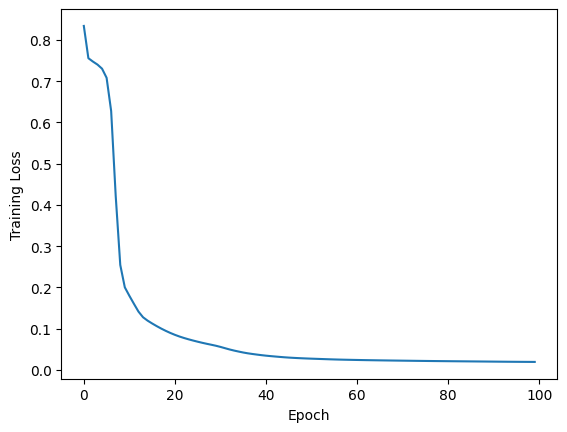

In [360]:
print('Test loss: %.6f' % test_loss_q11)
plot_pinn(test_dataset_q11, train_losses_q11, outputs_q11)

In [362]:
params_learnt_q11 = Params2Vec(net_q11.parameters())
directions_vec_1_q11 = get_direction_vector(net_q11)
directions_vec_2_q11 = get_direction_vector(net_q11)

range_q11 = torch.linspace(-20, 20, 50)
alpha, beta = torch.meshgrid(range_q11, range_q11)

eval_net_q11 = Net_general(2, 20, 4, activation_function=torch.tanh)
criterion_q11 = nn.MSELoss()
test_loss = 0.0
lls_q11 = []
for i,a in enumerate(alpha.flatten()):
        test_loss = 0.0
        with torch.no_grad():
          for inputs, targets in test_loader_q10:
            Vec2Params(  params_learnt_q11 + a * directions_vec_1_q11 + beta.flatten()[i] * directions_vec_2_q11,  eval_net_q11.parameters())
            preds_q11, loss = test_pinn( eval_net_q11 , criterion_q11, test_loader_q11)
            test_loss += loss
          lls_q11.append(test_loss)

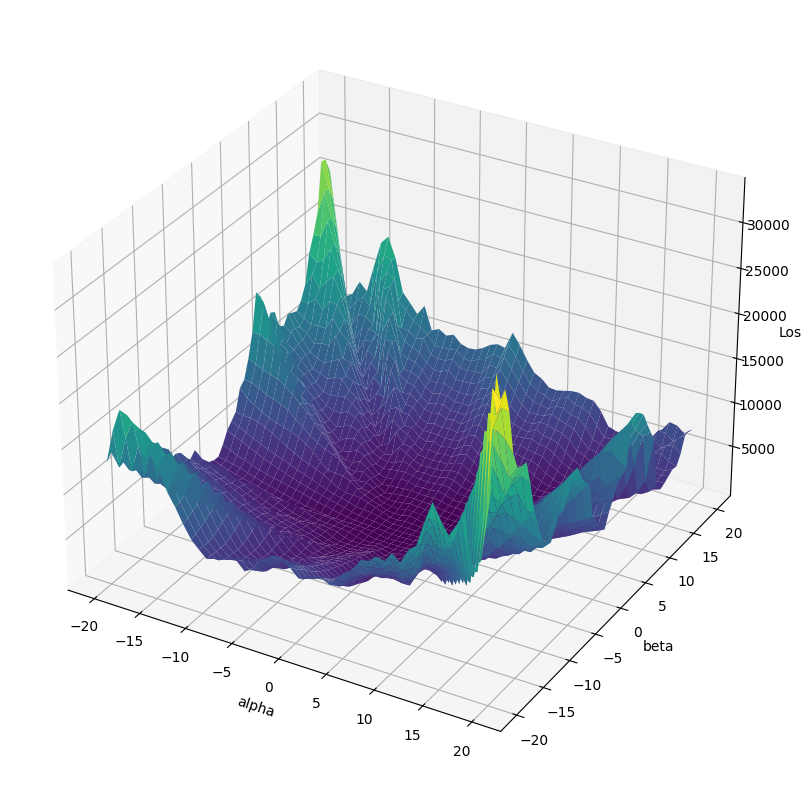

In [363]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(alpha, beta, np.array(lls_q11).reshape( alpha.shape ), cmap='viridis')
ax.set_xlabel('alpha')
ax.set_ylabel('beta')
ax.set_zlabel('Loss')
plt.show()

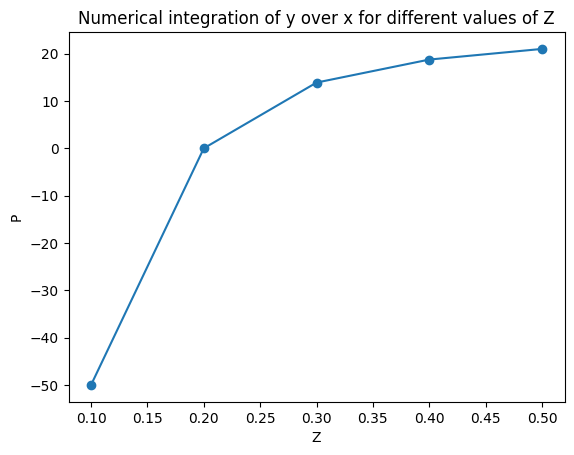

In [371]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# data samples
X = np.array([1, 2, 3, 4, 5])
Y = np.array([2, 4, 6, 8, 10])
Z = np.array([0.1, 0.2, 0.3, 0.4, 0.5])

# function to interpolate Y for given X
def y_function(x):
    return np.interp(x, X, Y)

# calculate lower limit of integration
def calculate_lower_limit(z):
    return 1 / z

P_values = []
for z in Z:
    lower_limit = calculate_lower_limit(z)
    upper_limit = X.max()
    result, _ = quad(y_function, lower_limit, upper_limit)
    P_values.append(result)

plt.plot(Z, P_values, marker='o')
plt.xlabel('Z')
plt.ylabel('P')
plt.title('Numerical integration of Y over X for different values of Z')
plt.show()


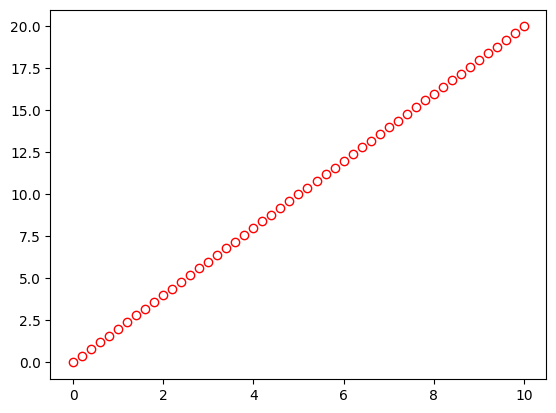

In [370]:
x = np.arange(0, 10.2, 0.2)
y = 2*x
plt.plot(x, y, 'ro', fillstyle = 'none')

In [ ]:
int = 0
for k in range(len(x) - 1):
    int = int + (y[k+1] + y[k])/2*(x[k+1] - x[k])
print('The numerical integral from our own For loop is:', int)